In [1]:
#Importing Necessary Libraries`

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [104]:
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/DSData/master/loan_prediction.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [105]:
# Loan_ID is not going to help in any way in our model prediction.
df = df.drop('Loan_ID',axis=1)

In [106]:
df['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [107]:
df.shape # 614 Rows and 13 columns


(614, 12)

In [108]:
df.describe() # Five columns are having numerical values

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [109]:
df.info() # we have integer, float and object datatype in our dataset
# We have missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [110]:
#Print all of the Object data_types and their unique values
for column in df.columns:
    if df[column].dtype == object:
        print(str(column) + ' : ' + str(df[column].unique()))
        print(df[column].value_counts())
        print('_____________________________________________________________________________________________')

Gender : ['Male' 'Female' nan]
Male      489
Female    112
Name: Gender, dtype: int64
_____________________________________________________________________________________________
Married : ['No' 'Yes' nan]
Yes    398
No     213
Name: Married, dtype: int64
_____________________________________________________________________________________________
Dependents : ['0' '1' '2' '3+' nan]
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
_____________________________________________________________________________________________
Education : ['Graduate' 'Not Graduate']
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
_____________________________________________________________________________________________
Self_Employed : ['No' 'Yes' nan]
No     500
Yes     82
Name: Self_Employed, dtype: int64
_____________________________________________________________________________________________
Property_Area : ['Urban' 'Rural' 'Semiurban']
Semiurban    23

In [111]:
df['Gender'] = df['Gender'].fillna( df['Gender'].dropna().mode().values[0] ) # Filling null values with mode
df['Married'] = df['Married'].fillna( df['Married'].dropna().mode().values[0] ) # Filling null values with mode
df['Dependents'] = df['Dependents'].fillna( df['Dependents'].dropna().mode().values[0] ) # Filling null values with mode
df['Self_Employed'] = df['Self_Employed'].fillna( df['Self_Employed'].dropna().mode().values[0] ) # Filling null values with mode
df['LoanAmount'] = df['LoanAmount'].fillna( df['LoanAmount'].dropna().mean() ) # Filling null values with mean
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna( df['Loan_Amount_Term'].dropna().mode().values[0] ) # Filling null values with mode
df['Credit_History'] = df['Credit_History'].fillna( df['Credit_History'].dropna().mode().values[0] ) # Filling null values with mode
df['Dependents'] = df['Dependents'].str.rstrip('+') # Removing '+' from the values

# Transforming our data to numerical datatype 
df['Gender'] = df['Gender'].map({'Female':0,'Male':1}).astype(np.int) # 0 for Female and 1 for Male
df['Married'] = df['Married'].map({'No':0, 'Yes':1}).astype(np.int) # 0 for NO and 1 for YES
df['Education'] = df['Education'].map({'Not Graduate':0, 'Graduate':1}).astype(np.int) # 0 for Non-Graduate and 1 for Graduate
df['Self_Employed'] = df['Self_Employed'].map({'No':0, 'Yes':1}).astype(np.int) # 0 for No and 1 for Yes
df['Loan_Status'] = df['Loan_Status'].map({'N':0, 'Y':1}).astype(np.int) # 0 for N and 1 for Y
df['Dependents'] = df['Dependents'].astype(np.int) #changing it to integer datatype

In [112]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,1,0,5849,0.0,146.412162,360.0,1.0,Urban,1
1,1,1,1,1,0,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,1,1,0,1,1,3000,0.0,66.000000,360.0,1.0,Urban,1
3,1,1,0,0,0,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,1,0,0,1,0,6000,0.0,141.000000,360.0,1.0,Urban,1


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int32  
 1   Married            614 non-null    int32  
 2   Dependents         614 non-null    int32  
 3   Education          614 non-null    int32  
 4   Self_Employed      614 non-null    int32  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int32  
dtypes: float64(4), int32(6), int64(1), object(1)
memory usage: 43.3+ KB


In [114]:
from sklearn.preprocessing import LabelEncoder

for column in df.columns:
    if df[column].dtype == np.number:
        continue
    df[column] = LabelEncoder().fit_transform(df[column])

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int32  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int32(1), int64(7)
memory usage: 55.3 KB


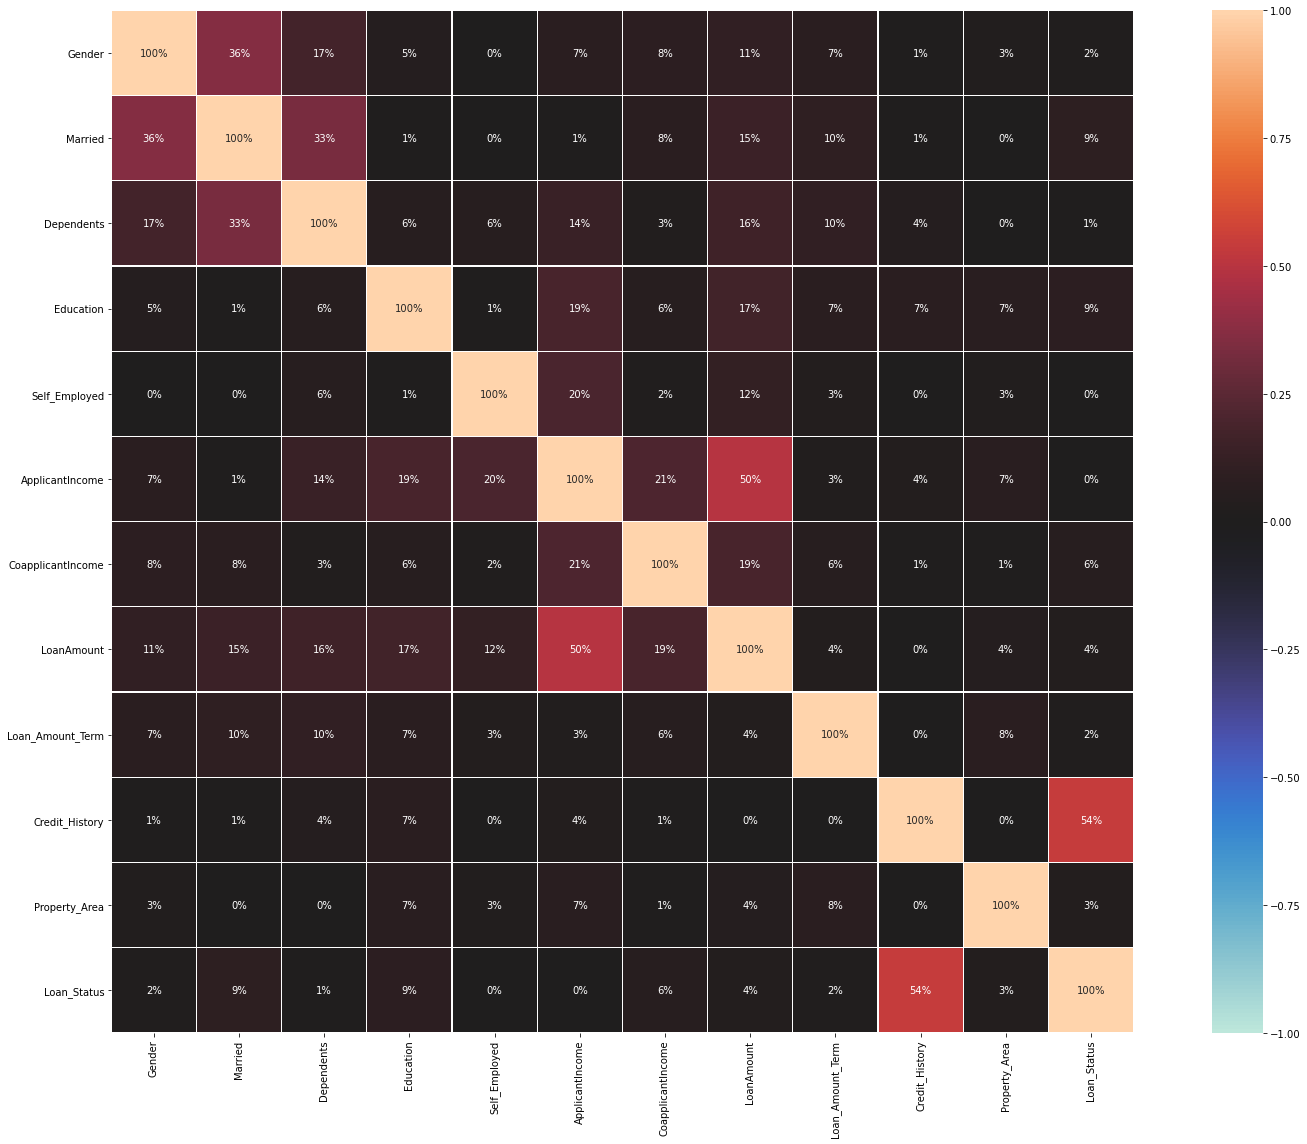

In [116]:
df_corr = df.corr().abs()
plt.figure(figsize = (22,16))
sns.heatmap(df_corr, vmin = -1, vmax = 1, annot = True, square = True, center = 0, fmt = '.0%', linewidths = .1)
plt.tight_layout()

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

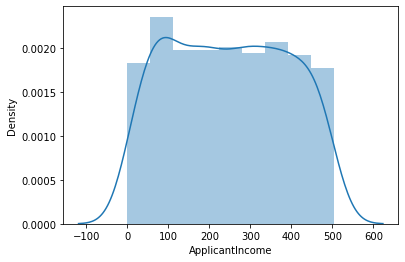

In [117]:
sns.distplot(df['ApplicantIncome'])

<AxesSubplot:xlabel='CoapplicantIncome', ylabel='Density'>

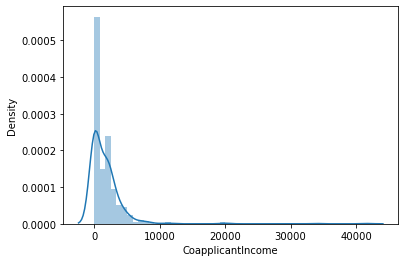

In [118]:
sns.distplot(df['CoapplicantIncome'])

<AxesSubplot:xlabel='LoanAmount', ylabel='Density'>

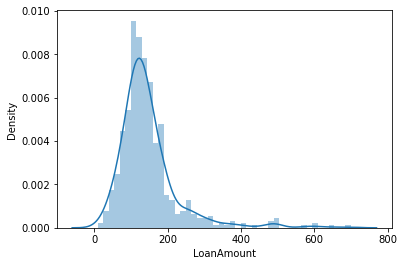

In [119]:
sns.distplot(df['LoanAmount'])

<AxesSubplot:xlabel='ApplicantIncome'>

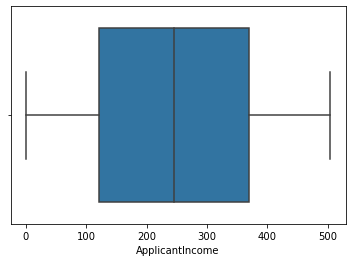

In [120]:
sns.boxplot(df['ApplicantIncome']) # No outliers in this column

<AxesSubplot:xlabel='CoapplicantIncome'>

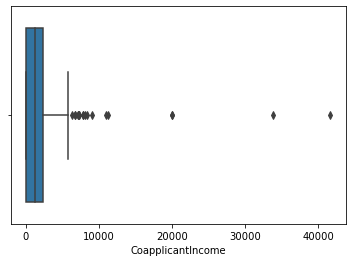

In [121]:
sns.boxplot(df['CoapplicantIncome']) # outliers in this column

<AxesSubplot:xlabel='LoanAmount'>

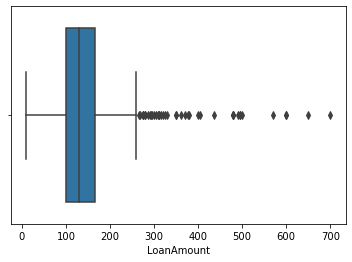

In [122]:
sns.boxplot(df['LoanAmount']) # outliers in this column

# IQR for outlier removal

In [123]:
percentile25 = df['CoapplicantIncome'].quantile(0.25)
percentile75 = df['CoapplicantIncome'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

upper_limit

5743.125

In [124]:
df = df[df['CoapplicantIncome'] < upper_limit]

In [125]:
percentile25 = df['LoanAmount'].quantile(0.25)
percentile75 = df['LoanAmount'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

upper_limit

250.0

In [126]:
df = df[df['LoanAmount'] < upper_limit]

In [127]:
df.shape # We still have more than 89% of data retained

(551, 12)

<AxesSubplot:xlabel='LoanAmount', ylabel='Density'>

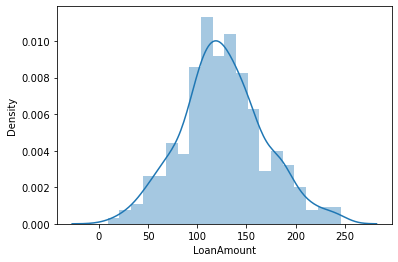

In [128]:
sns.distplot(df['LoanAmount'])

In [129]:
df['Loan_Status'].value_counts() # class Imbalance

1    383
0    168
Name: Loan_Status, dtype: int64

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

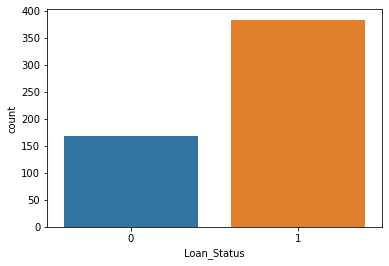

In [130]:
sns.countplot(df['Loan_Status']) # class Imbalance

In [132]:
X = df.drop(columns = ['Loan_Status'], axis = 1)
Y = df['Loan_Status']

In [133]:
#split the data into 75% training and 25% testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75, random_state = 27)

# Upsampling of our label

In [134]:
from sklearn.utils import resample
X = pd.concat([X_train, Y_train], axis = 1)
Y = X[X.Loan_Status ==1]
N = X[X.Loan_Status ==0]

In [135]:
Y.shape

(283, 12)

In [136]:
N.shape

(130, 12)

In [137]:
N_upsampled = resample(N, replace = True, n_samples = len(Y), random_state = 22) # upsampling

In [138]:
upsampled = pd.concat([Y, N_upsampled])

In [139]:
upsampled.Loan_Status.value_counts()

1    283
0    283
Name: Loan_Status, dtype: int64

In [140]:
upsampled

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
362,1,1,0,1,0,323,2333.0,130.000000,360.0,1.0,2,1
247,1,1,1,0,0,404,0.0,137.000000,180.0,1.0,2,1
164,1,1,0,1,0,444,0.0,75.000000,180.0,1.0,2,1
527,1,1,1,0,0,349,1430.0,161.000000,360.0,0.0,1,1
475,1,1,2,1,1,483,1014.0,150.000000,360.0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23,1,1,2,0,0,190,1917.0,112.000000,360.0,0.0,0,0
291,1,1,2,1,0,299,0.0,127.000000,360.0,0.0,1,0
550,1,1,2,1,1,405,0.0,146.412162,360.0,0.0,0,0
66,1,0,0,0,0,171,2254.0,126.000000,180.0,0.0,2,0


In [141]:
x = upsampled.drop(columns = ['Loan_Status'], axis = 1)
y = upsampled['Loan_Status']

# Scaling

In [142]:
# StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)

# Variance inflation factor

In [143]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(x_scaler,i) for i in range(x_scaler.shape[1])]
vif["Features"] = x.columns

In [144]:
vif

,vif,Features
0,1.206884,Gender
1,1.359639,Married
2,1.228377,Dependents
3,1.116469,Education
4,1.037348,Self_Employed
5,1.583599,ApplicantIncome
6,1.471429,CoapplicantIncome
7,1.599743,LoanAmount
8,1.046200,Loan_Amount_Term
9,1.028654,Credit_History


# Train test split

In [161]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaler, y, train_size = 0.75, random_state = 27)

# Logistic regression

In [200]:
log_reg = LogisticRegression()

In [201]:
log_reg.fit(x_train, y_train) # training our model

LogisticRegression()

In [202]:
log_reg.score(x_train, y_train) # Training score

0.7594339622641509

In [203]:
y_pred = log_reg.predict(x_test) # Prediction

In [204]:
log_reg.score(x_test, y_test) # Test Score

0.6619718309859155

In [205]:
accuracy = accuracy_score(y_test, y_pred) #Accuracy
accuracy

0.6619718309859155

# KNearest neighbour 

In [206]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1) #Iterating from 1 to 5 to check the best value of n_neighbors
knn.fit(x_train, y_train) # Training our model

KNeighborsClassifier(n_neighbors=1)

In [207]:
knn.score(x_train, y_train)

1.0

In [208]:
knn.score(x_test, y_test)

0.8591549295774648

# Decision Tree Classifier

In [209]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train) # Training the model 

DecisionTreeClassifier()

In [210]:
dt.score(x_train, y_train)

1.0

In [211]:
dt.score(x_test, y_test)

0.852112676056338

# Random Forest Classifier

In [212]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [213]:
clf.fit(x_train, y_train) # Training model with train data

RandomForestClassifier()

In [214]:
clf.score(x_train, y_train)

1.0

In [215]:
clf.score(x_test, y_test)

0.9154929577464789

# Plotting curve

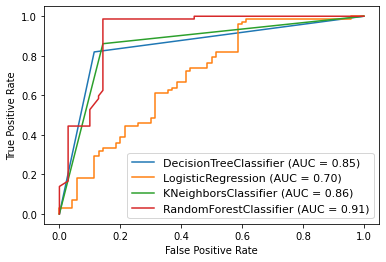

In [216]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve


disp = plot_roc_curve(dt, x_test, y_test)
plot_roc_curve(log_reg, x_test, y_test, ax = disp.ax_)
plot_roc_curve(knn, x_test, y_test, ax = disp.ax_)
plot_roc_curve(clf, x_test, y_test, ax = disp.ax_)
plt.legend(prop = {'size' : 11}, loc = 'lower right')
plt.show()

We can see that RandomForestClassifier is the best model for this dataset as it is covering maximum area under it's curve

# HyperParameter Tuning

In [217]:
CLF = RandomForestClassifier()

In [423]:
params = {'n_estimators':[100,110],
         'criterion':['entropy','ginni'],
         'min_samples_split':[2,5],
         'min_samples_leaf':[1,2],
         }

grd = GridSearchCV(clf, param_grid = params)
grd.fit(x_train, y_train)
print('best_param = >', grd.best_params_)

best_param = > {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [424]:
grd.best_score_

0.8984873949579832

In [430]:
CLF = RandomForestClassifier(criterion='entropy', min_samples_leaf=1,
                       min_samples_split=2, n_estimators=100)

In [431]:
CLF.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy')

In [432]:
CLF.score(x_train, y_train) # Score for train data

1.0

In [434]:
CLF.score(x_test, y_test) # Score for test data

0.8943661971830986

In [435]:
roc_auc_score(y_test, CLF.predict(x_test))

0.8938492063492064

With Hyperparameter tuning our score didn't improve much and hence we consider the random forest classifier model as our best model.

# Saving our model

In [422]:
import pickle
filename = "Loan Prediction"
pickle.dump(clf, open(filename,'wb'))